1. QnA from table
2. recommender
3. search tool
4. summariser

In [ ]:
!unzip  -d . /content/microlabs_usa_cleaned.zip
# %pip install -qU groq langgraph langsmith langchain-groq langchain_community langchain-text-splitters langchain-core langchain_experimental
# !apt install jq
# !pip -q install langchain-ai21
# %pip install -qU langchain-text-splitters
# !pip install chromadb langchain-chroma
# !pip install langchain faiss-cpu transformers sentence-transformers
# !pip install -qU langchain_experimental

In [ ]:
import os
from langchain_groq import ChatGroq
from groq import Groq
from langchain_groq import ChatGroq

os.environ['GROQ_API_KEY'] = "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"

llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [ ]:
# !jq 'paths | map(tostring) | join(".") as $path | $path + ": " + (getpath($path | split(".")) | type)' /content/dataset/datasets/microlabs_usa/Acetazolamide_Extended-Release_Capsules.json
# !jq keys /content/dataset/datasets/microlabs_usa/Acetazolamide_Extended-Release_Capsules.json

[
  "ADVERSE REACTIONS:",
  "CLINICAL PHARMACOLOGY:",
  "CONTRAINDICATIONS:",
  "DESCRIPTION:",
  "DOSAGE AND ADMINISTRATION:",
  "HOW SUPPLIED:",
  "INDICATIONS AND USAGE:",
  "INGREDIENTS AND APPEARANCE",
  "OVERDOSAGE:",
  "PACKAGE LABEL.PRINCIPAL DISPLAY PANEL",
  "PRECAUTIONS:",
  "WARNINGS:",
  "product_name"
]


In [ ]:
from langchain_text_splitters import RecursiveJsonSplitter
from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_text_splitters import RecursiveCharacterTextSplitter
import json
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=5000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)

def split_and_chunk(path,text_splitter):
  """returns a list of documents which has been split key-wise and then length wise"""
  for root,folders,files in os.walk(path):
    all_documents = []
    for file in files:
        file_path = os.path.join(root,file)
        with open(file_path) as user_file:
          file_contents = user_file.read()
        json_data = json.loads(file_contents)
        for key,val in json_data.items():
          json_chunks = text_splitter.create_documents([val])
          for chunk in json_chunks:
            chunk.metadata["product_name"] = file
            chunk.metadata["key"] = key
            all_documents.append(chunk)
  return all_documents

def create_vector_store(documents, embedding_model="sentence-transformers/all-MiniLM-L6-v2"):
    embeddings = HuggingFaceEmbeddings(model_name=embedding_model)
    vector_store = FAISS.from_documents(documents, embeddings)
    vector_store.save_local("faiss_index")
    return vector_store

path = "/content/dataset/datasets/microlabs_usa"
all_documents = split_and_chunk(path,text_splitter)
vector_store = create_vector_store(all_documents)

In [ ]:
from langchain.prompts import PromptTemplate

question = "Summarize the mechanisms of action, indications, and potential benefits of combining Bimatoprost Ophthalmic Solution."

prompt = """
You are a helpful assistant. based on the provided document, answer the question as accurately as possible.
Documents: {documents}
Question: {question}
Answer:
"""

prompt_template = PromptTemplate(input_variables=["documents", "question"], template=prompt)
retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "score_threshold": 0.5,
        "k": 3
    }
)

qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever, verbose=True)
answer = qa_chain.run(question)
print(answer)



> Entering new RetrievalQA chain...

> Finished chain.
Based on the provided information, here is a summary of the mechanisms of action, indications, and potential benefits of Bimatoprost Ophthalmic Solution:

**Mechanisms of Action:**

* Bimatoprost ophthalmic solution is a prostaglandin analog that reduces elevated intraocular pressure (IOP) in patients with open-angle glaucoma or ocular hypertension.
* It works by increasing the outflow of aqueous humor from the eye, thereby reducing IOP.

**Indications:**

* Bimatoprost ophthalmic solution is indicated for the reduction of elevated IOP in patients with open-angle glaucoma or ocular hypertension.

**Potential Benefits:**

* Reduces elevated IOP, which can help prevent vision loss and blindness caused by glaucoma.
* May help slow or stop the progression of glaucoma.
* Can be used as a monotherapy or in combination with other medications to control IOP.

**Combining with Other Medications:**

* The potential benefits of combining Bi

In [ ]:
#SUMMARISER
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)
retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "score_threshold": 0.5,
    }
)

question = "Summarize the mechanisms of action, indications, and potential benefits of combining Dorzolamide HCl Ophthalmic Solution, Bimatoprost Ophthalmic Solution, and Timolol Maleate Ophthalmic Solution."
docs = retriever.invoke(question)
result = chain.invoke({"context": docs})
print(result)

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'ellipsis'>

In [ ]:
#Recommendation
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Make Recommendations based on this:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)
retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "score_threshold": 0.5,
    }
)

question = "Summarize the dosage, side eﬀects, and indications for Dorzolamide HCl and Timolol Maleate Ophthalmic Solution"
docs = retriever.invoke(question)
result = chain.invoke({"context": docs})
print(result)

Based on the provided information, here are some recommendations:

**Recommendation 1:** If you are considering prescribing Bimatoprost ophthalmic solution to a patient under the age of 16, do not do so. The product labeling recommends against use in pediatric patients below the age of 16 due to potential safety concerns related to increased pigmentation following long-term chronic use.

**Recommendation 2:** Be aware of the potential side effects of Bimatoprost ophthalmic solution, including conjunctival hyperemia, pigmentation of the iris, periorbital tissue, and eyelashes, and eyelash changes such as increased length, thickness, and number of lashes.

**Recommendation 3:** Educate patients about the importance of continued follow-up appointments to monitor the effectiveness of treatment and detect any potential long-term side effects.

**Recommendation 4:** Consider alternative treatments for open-angle glaucoma or ocular hypertension if a patient has a history of hypersensitivity t

In [ ]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "product_ret",
    "Searches and returns products",
)

In [ ]:
from langchain.agents import initialize_agent, Tool
from langchain.chains import RetrievalQA, LLMChain
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.vectorstores import VectorStore


llm = ...  # Your language model instance (e.g., OpenAI, Anthropic)
vector_store = ...  # Your vector store for document retrieval
tavily_search_tool = Tool(
    name="TavilySearch",
    func=...,  # Functionality for TavilySearch integration
    description="Search and retrieve external information."
)

# Tool 1: Q&A Agent
qa_prompt = """
You are a helpful assistant. Based on the provided documents, answer the question as accurately as possible.
If there is no relevant data or the question is out of scope, respond that you cannot answer.
Documents: {documents}
Question: {question}
Answer:
"""
qa_prompt_template = PromptTemplate(input_variables=["documents", "question"], template=qa_prompt)

qa_retriever = vector_store.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5, "k": 3})
qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=qa_retriever, verbose=True)

qa_agent = Tool(
    name="Q&A Agent",
    func=qa_chain.run,
    description="Answers questions based on provided documents."
)

# Tool 2: Recommendation Agent
rec_prompt = ChatPromptTemplate.from_messages([("system", "Make recommendations based on this:\n\n{context}")])
rec_chain = create_stuff_documents_chain(llm, rec_prompt)

rec_agent = Tool(
    name="Recommendation Agent",
    func=lambda context: rec_chain.invoke({"context": context}),
    description="Generates recommendations based on context."
)

# Tool 3: Summarization Agent
sum_prompt = ChatPromptTemplate.from_messages([("system", "Write a concise summary of the following:\n\n{context}")])
sum_chain = create_stuff_documents_chain(llm, sum_prompt)

sum_agent = Tool(
    name="Summarization Agent",
    func=lambda context: sum_chain.invoke({"context": context}),
    description="Summarizes information concisely."
)

# Tool 4: TavilySearch Agent
search_agent = Tool(
    name="Search Agent",
    func=tavily_search_tool.func,
    description="Searches the web for relevant information using TavilySearch."
)

# Combine tools into a multi-agent LangGraph
tools = [qa_agent, rec_agent, sum_agent, search_agent]

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent="zero-shot-react-description",  # Agent type
    verbose=True
)

# Example Usage
question = "Summarize the dosage, side effects, and indications for Dorzolamide HCl and Timolol Maleate Ophthalmic Solution"
result = agent.run(question)
print(result)

In [ ]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

from langgraph.prebuilt import tools_condition
tools = [retriever_tool]

### Edges

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = llm

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = llm
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = llm
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = """
      You are a helpful assistant. based on the provided document, answer the question as accurately as possible.
      If there is not relevant data o the question appears to be out of scope you can not answer.
      Documents: {context}
      Question: {question}
      Answer:
      """

    prompt_template = PromptTemplate(input_variables=["context", "question"], template=prompt)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

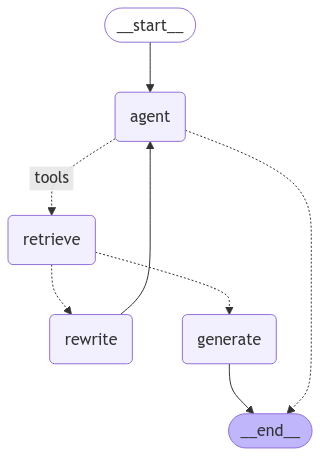

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import pprint

inputs = {
    "messages": [
        ("user", "What is the primary indication for Acetazolamide?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

ValueError: Last message is not an AIMessage

In [ ]:
# import chromadb
# from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings
# client = chromadb.PersistentClient(
#     path="test",
#     settings=Settings(),
#     tenant=DEFAULT_TENANT,
#     database=DEFAULT_DATABASE,
# )

# collection.add(
#     all_documents,
# )
# results = collection.query(
#     query_texts=["This is a query document about hawaii"], # Chroma will embed this for you
#     n_results=2 # how many results to return
# )
# print(results)